In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

algorithm_globals.random_seed = 42

# Declare Quantum Instance
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Data loading

First, we load the corresponding dataset and extract the train and test splits

In [ ]:
npz_dst = np.load('../data/CMAPSS_FD001_STAT_PCA.npz')

X_train, Y_train = npz_dst['X_train'], npz_dst['Y_train']
X_test, Y_test = npz_dst['X_test'], npz_dst['Y_test']

print( 'train split: {:d} samples'.format(X_train.shape[0]) )
print( '\ntrain rest split: {:d} samples'.format(X_train_rest.shape[0]) )

print( '\ntest split: {:d} samples'.format(X_test.shape[0]) )
print( '\ntest rest split: {:d} samples'.format(X_test_rest.shape[0]) )

train split: 100 samples

train rest split: 20 samples

test split: 100 samples

test rest split: 20 samples


Now we generate binary labels for datasets

In [ ]:
X = X_train
y01 = Y_train  # in { 0,  1}, y01 will be used for CircuitQNN
y = 2 * Y_train - 1  # in {-1, +1}, y will be used for OplowQNN

X_test = X_test
y01_test = Y_test
y_test = 2 * Y_test - 1

Then we convert the data to Torch Tensors

In [ ]:
# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

X_test_ = Tensor(X_test)
y01_test_ = Tensor(y01_test).reshape(len(y_test)).long()
y_test_ = Tensor(y_test).reshape(len(y_test), 1)

## A. Classification with `OpflowQNN`

Linking an `OpflowQNN` to PyTorch is relatively straightforward. Here we use this using the `TwoLayerQNN`, a sub-case of `OpflowQNN`.

#### Model Building

First, based on the dataset shape, we define the FeatureMap and its number of qubits. On this step we used `ZZFeatureMap`, `ZFeatureMap` or `RawFeatureVector`. Also we define `RealAmplitudes` as the Ansatz for the QNN and finally initializate the Pytorch Module.

In [ ]:
num_inputs = X_train.shape[1]
qnn1 = TwoLayerQNN(num_qubits=num_inputs, feature_map=ZZFeatureMap, ansatz=RealAmplitudes, quantum_instance=qi)
print(qnn1.operator)

# Set up PyTorch module
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

ComposedOp([
  OperatorMeasurement(1.0 * ZZZZZ),
  CircuitStateFn(
       ┌─────────────────────────────────────────┐»
  q_0: ┤0                                        ├»
       │                                         │»
  q_1: ┤1                                        ├»
       │                                         │»
  q_2: ┤2 ZZFeatureMap(x[0],x[1],x[2],x[3],x[4]) ├»
       │                                         │»
  q_3: ┤3                                        ├»
       │                                         │»
  q_4: ┤4                                        ├»
       └─────────────────────────────────────────┘»
  «     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
  «q_0: ┤0                                                                                                                               ├
  «     │                                                                          

Now we plot the Feature Map

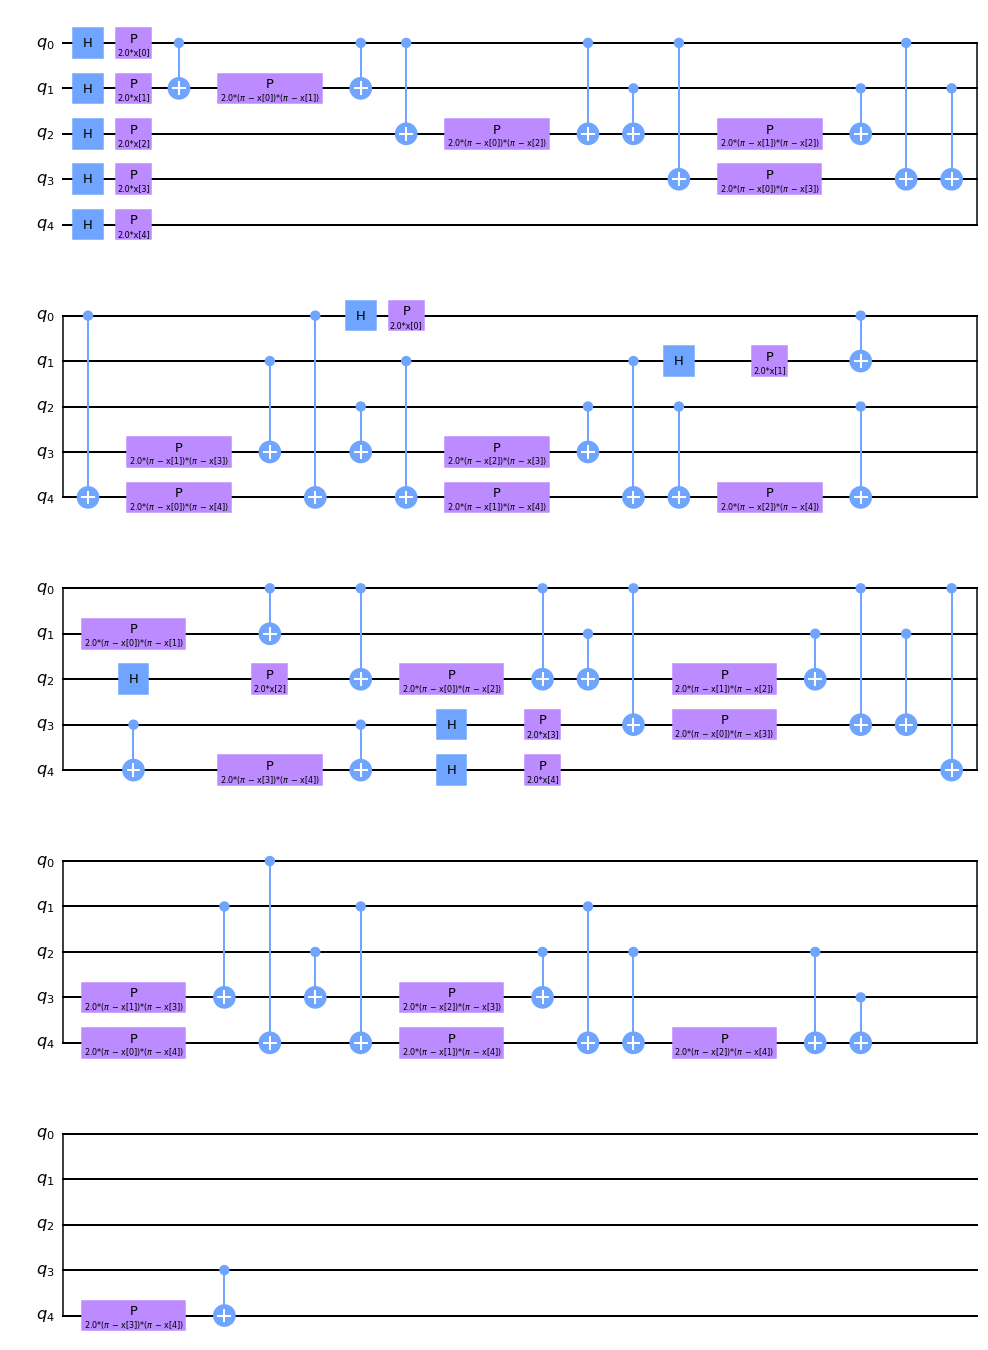

In [ ]:
feature_map = qnn1.feature_map
feature_map.decompose().draw(output="mpl", fold=20)

And then we plot the Ansatz.

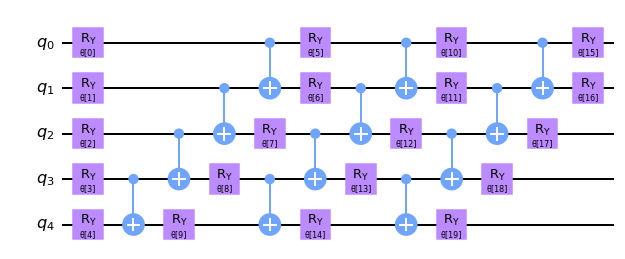

In [ ]:
ansatz = qnn1.ansatz
ansatz.decompose().draw(output="mpl", fold=20)

Now we define the optimization rutine. We initialize the optimizer and the loss function.

In [ ]:
# Define optimizer and loss function
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

### Model training

Now we start the model training

In [ ]:
import time

# Start model training
start = time.time()
model1.train()  

# Some optimization algorithms such as LBFGS need to reevaluate the function multiple times, 
# so you have to pass in a closure function that allows them to recompute the model.
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_), y_)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer
optimizer.step(closure)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

88.41305541992188
83.81999206542969
84.84342956542969
79.37095642089844
78.77925109863281
78.334716796875
78.0921401977539
77.83992767333984
77.76280975341797
77.61235809326172
77.59428405761719
77.57537078857422
77.53173828125
77.31910705566406
77.00226593017578
81.89820098876953
76.2911376953125
78.19487762451172
75.30528259277344
75.01374053955078


tensor(88.4131, grad_fn=<MseLossBackward0>)
Training time: 1620 seconds 


### Model evaluation
Finally we evaluate the model and we plot the confussion matrix. First, with the train dataset.

In [ ]:
# Model Evaluation
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]
    
y_predict_test = []
for x, y_target in zip(X_test, y_test):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

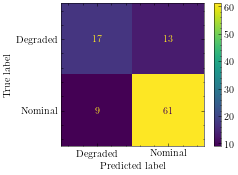

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

labels_predict_train = y_predict

#matriz de confusion
cm_train = confusion_matrix(y, y_predict, labels=[-1, 1])

# plot de matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Degraded', 'Nominal'])

disp.plot()
plt.show()

# Save Confussion Matrix
name = "PYTORCH_QNN_OPFLOWQNN_ZZFEATUREMAP_REALAMPLITUDES_LBFGSOPT_CMAPSS_STATISTICS_TRAIN"
plt.savefig("../outputs/TORCHQNN/CMAPSS/STAT/"+name+".pdf", format='pdf', bbox_inches='tight')

Then with the test dataset.

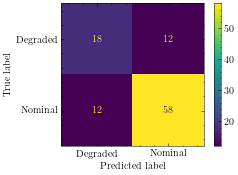

In [ ]:
labels_predict_test = y_predict_test

#matriz de confusion
cm_test = confusion_matrix(y, y_predict_test, labels=[-1, 1])

# plot de matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Degraded', 'Nominal'])

disp.plot()
plt.show()

# Save Confussion Matrix
name = "PYTORCH_QNN_OPFLOWQNN_ZZFEATUREMAP_REALAMPLITUDES_LBFGSOPT_CMAPSS_STATISTICS_TEST"
plt.savefig("../outputs/TORCHQNN/CMAPSS/STAT/"+name+".pdf", format='pdf', bbox_inches='tight')

Then we compute accuracy, but first we define a function to calculate evaluation metrics.

In [ ]:
def metrics(matrix):
    TP = matrix[0, 0]
    FP = matrix[0, 1]
    FN = matrix[1, 0]
    TN = matrix[1, 1]
    # Metrics calculation
    total = TP + FP + FN + TN
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    npv = TN / (TN + FN)

    # Print the results
    print(f"Precision: {precision:.2f}\nRecall: {recall:.2f}\nSpecificity: {specificity:.2f}\nNPV: {npv:.2f}")
    

print("Quantum VQC on the training dataset:")
print("Accuracy:", sum(y_predict == y) / len(y))
metrics(cm_train)
print("\nQuantum VQC on the test dataset:")
print("Accuracy:", sum(y_predict == y) / len(y))
metrics(cm_test)

Quantum VQC on the training dataset:
Accuracy: 0.78
Precision: 0.57
Recall: 0.65
Specificity: 0.82
NPV: 0.87

Quantum VQC on the test dataset:
Accuracy: 0.76
Precision: 0.60
Recall: 0.60
Specificity: 0.83
NPV: 0.83


## B. Classification with `CircuitQNN`

#### Model Building
We define the FeatureMap and its number of qubits. On this step we used `ZZFeatureMap`, `ZFeatureMap` or `RawFeatureVector`. Also we define `RealAmplitudes` as the Ansatz for the QNN and finally initializate the Pytorch Module.

In [ ]:
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement="linear", reps=1)

# Append feature map and ansatz ond a Quantum Circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))


# Define CircuitQNN and initial setup
parity = lambda x: "{:b}".format(x).count("1") % 2  #  interpret function
output_shape = 2  # parity = 0, 1
qnn2 = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=qi,
)

# Set up PyTorch module
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print("Initial weights: ", initial_weights)
model2 = TorchConnector(qnn2, initial_weights)

Initial weights:  [ 0.03368059 -0.00578076  0.01304722  0.05299977  0.02694366  0.01071588
  0.01184143 -0.03920998 -0.09383643 -0.01265652]


#### Model Training
In the same way as the previous case, we define the model, optimizer and loss function, also we start the training and the optimizer routine.

In [ ]:
# Define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range

# Start training
start = time.time()
model2.train()

# Define LBFGS closure method (explained in previous section)
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model2(X_), y01_)  # Calculate loss
    loss.backward()  # Backward pass

    print(loss.item())  # Print loss
    return loss


# Run optimizer (LBFGS requires closure)
optimizer.step(closure);
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

0.7028264403343201
0.7019930481910706
0.6853245496749878
0.712104856967926
0.690920889377594
0.6994035243988037
0.6976688504219055
0.6819828748703003
0.6884312629699707
0.6912134289741516
0.6854918003082275
0.7035934329032898
0.6956887245178223
0.7056882977485657
0.7057328224182129
0.6908510327339172
0.6869394183158875
0.6878055334091187
0.688737154006958
0.7085148692131042

Training Time: 540 seconds 


#### Model evaluation

Finally we do the same evaluation process as the previous case

In [ ]:
# Model Evaluation
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]
    
y_predict_test = []
for x in X_test:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]


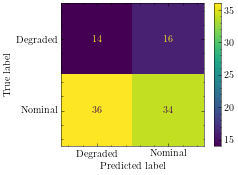

In [ ]:
labels_predict_train = y_predict

#matriz de confusion
cm_train = confusion_matrix(y01, y_predict, labels=[0, 1])

# plot de matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Degraded', 'Nominal'])

disp.plot()
plt.show()

# Save Confussion Matrix
name = "PYTORCH_QNN_CIRCUITQNN_ZZFEATUREMAP_REALAMPLITUDES_LBFGSOPT_CMAPSS_STATISTICS_TRAIN"
plt.savefig("../outputs/TORCHQNN/CMAPSS/STAT/"+name+".pdf", format='pdf', bbox_inches='tight')

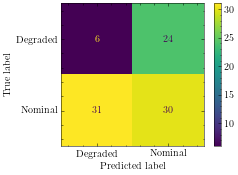

In [ ]:
labels_predict_test = y_predict_test

#matriz de confusion
cm_test = confusion_matrix(y01_test, y_predict_test, labels=[0, 1])

# plot de matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Degraded', 'Nominal'])

disp.plot()
plt.show()

# Save Confussion Matrix
name = "PYTORCH_QNN_CIRCUITQNN_ZZFEATUREMAP_REALAMPLITUDES_LBFGSOPT_CMAPSS_STATISTICS_TEST"
plt.savefig("../outputs/TORCHQNN/CMAPSS/STAT/"+name+".pdf", format='pdf', bbox_inches='tight')

In [ ]:
# Compute Evaluation Metrics
print("Quantum VQC on the training dataset:")
print("Accuracy:", sum(y_predict == y01) / len(y01))
metrics(cm_train)
print("\nQuantum VQC on the test dataset:")
print("Accuracy:", sum(y_predict == y01) / len(y01))
metrics(cm_test)

Quantum VQC on the training dataset:
Accuracy: 0.48
Precision: 0.47
Recall: 0.28
Specificity: 0.68
NPV: 0.49

Quantum VQC on the test dataset:
Accuracy: 0.45
Precision: 0.20
Recall: 0.16
Specificity: 0.56
NPV: 0.49
